# TP - Classification d'images

L'objectif de ce TP est multiple :
* prendre en main l'outil [Keras](https://keras.io/)
* prendre en main l'outil [TensorFlow](https://www.tensorflow.org/)
* prendre en main l'outil [PyTorch](https://pytorch.org/)
* construire une architecture convolutive pour la classification d'images.

Keras est devenue la core API de Tensorflow depuis la sortie de Tensorflow 2, utilisable en important `tf.keras`. C'est une excellente nouvelle qui allie la simplicité d'utilisation de Keras avec la robustesse de Tensorflow.

Néanmoins, nous vous proposons dans ce TP de "séparer" encore ces 2 API pour vous montrer différentes manière d'importer vos data, de gérer le preprocessing ainsi que de créer votre modèle. A vous ensuite de choisir l'implémentation que vous préférez ! 

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from zipfile import ZipFile
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

___

# Table des matières
* [**I. Le jeu de données CIFAR-100**](#part1)
    * [1) Téléchargement des données](#spart1)
    * [2) Lecture jeu de données](#spart2)
    * [3) Choix du type de labels](#spart3)
    * [4) Formatage des données](#spart4)
    * [5) Visualisation des données](#spart5)
* [**II. Classification d'images avec Keras**](#part2)
    * [Exercice n°1 : pré-traitement des données](#exo1)
    * [Exercice n°2 : pré-traitement des labels](#exo2)
    * [Exercice n°3 : construction d'un modèle convolutif](#exo3)
    * [Exercice n°4 : entraînement du modèle convolutif](#exo4)
    * [Exercice n°5 : prédiction sur le jeu de test](#exo5)
    * [Exercice n°6 : analyse d'erreurs](#exo6)
* [**III. Classification d'images avec TensorFlow**](#part3)
    * [Exercice n°7 : pré-traitement des données](#exo7)
    * [Exercice n°8 : chargement des données au fur et à mesure](#exo8)
    * [Exercice n°9 : construction d'un modèle convolutif](#exo9)
    * [Exercice n°10 : entraînement du modèle convolutif](#exo10)
    * [Exercice n°11 : prédiction sur le jeu de test](#exo11)
    * [Exercice n°12 : analyse d'erreurs](#exo12)
* [**IV. Classification d'images avec PyTorch**](#part4)
    * [Exercice n°13 : chargement des données au fur et à mesure](#exo13)
    * [Exercice n°14 : construction d'un modèle convolutif](#exo14)
    * [Exercice n°15 : entraînement du modèle convolutif](#exo15)
    * [Exercice n°16 : prédiction sur le jeu de test](#exo16)
    * [Exercice n°17 : analyse d'erreurs](#exo17)
* [**V. Conclusion**](#part5)

___

# I. Le jeu de données CIFAR-100

<a class='anchor' id='part1'></a>

Dans cette partie, on se propose de charger et reformater les données [CIFAR-100](http://www.cs.utoronto.ca/~kriz/cifar.html), disponibles en accès libre. Cette partie ne contient pas d'exercices.

## 1) Téléchargement des données

<a class='anchor' id='spart1'></a>

* Monter le Drive comme fait au TP précédent
* Télécharger la version python de [CIFAR-100](http://www.cs.utoronto.ca/~kriz/cifar.html)
* Placer la tarball dans le répertoire `datasets` 
* Décompresser (**Indice :** on pourra utiliser le package [Zipfile](https://docs.python.org/3/library/zipfile.html))

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
WORKING_DIR = 'drive/MyDrive/MLE_Fall_2020/TP'
os.chdir(WORKING_DIR)
path = os.path.join(os.getcwd(), 'datasets', 'cifar100.zip')

In [4]:
with ZipFile(path, 'r') as zipObj:
   zipObj.extractall(path='./datasets/')

In [5]:
!ls datasets

cifar100  cifar100.zip	__MACOSX  mnist.npz


## 2) Lecture jeu de données

<a class='anchor' id='spart2'></a>

Une fois décompressé, le répertoire `cifar100` contient trois fichiers :
* **train :** le jeu d'entraînement, 50 000 images labellisées selon 100 classes différentes
* **test :** le jeu de test, 10 000 images labellisées selon 100 classes différentes
* **meta :** le nom des labels en toutes lettres

Pour lire les trois fichiers, on fournit la fonction `unpickle`. En particulier, elle convertit les clefs des dictionnaires en chaînes de caractères.

**Consigne :** Utilisez cette fonction pour extraire les trois dictionnaires pour les données d'entraînement, de test, et les labels en toutes lettres.

In [8]:
def unpickle(file):
  """
    Unpickle CIFAR-100 files to return a dictionary
    
    Parameters
    ----------
    file : str
        path of file to unpicke
    
    Returns
    -------
    decoded : dict
        dictionary of corresponding file (train, test, labels)
    """

  with open(file, 'rb') as f:
    data = pickle.load(f, encoding='bytes')
    decoded = {}
    for k, v in data.items():
      decoded[k.decode('utf8')] = v
  return decoded

In [9]:
dict_train = unpickle(os.path.join('datasets', 'cifar100', 'train'))
dict_test = unpickle(os.path.join('datasets', 'cifar100', 'test'))
dict_labels = unpickle(os.path.join('datasets', 'cifar100', 'meta'))

**Consigne :** Explorez brièvement les dictionnaires que vous avez obtenus.

- Quels sont les couples de clé-valeur ?
- Quel est le type de chaque valeur ? La taille ? 

In [10]:
print("Keys for Train : {}".format(list(dict_train.keys())))
print("Keys for Train : {}".format(list(dict_test.keys())))
print("Keys for Train : {}".format(list(dict_labels.keys())))

Keys for Train : ['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data']
Keys for Train : ['filenames', 'batch_label', 'fine_labels', 'coarse_labels', 'data']
Keys for Train : ['fine_label_names', 'coarse_label_names']


In [11]:
kind = 'coarse'
print("Length of {} list : {}\n".format(kind, len(dict_labels['{}_label_names'.format(kind)])))
print(*dict_labels['{}_label_names'.format(kind)], sep = "\n")

Length of coarse list : 20

b'aquatic_mammals'
b'fish'
b'flowers'
b'food_containers'
b'fruit_and_vegetables'
b'household_electrical_devices'
b'household_furniture'
b'insects'
b'large_carnivores'
b'large_man-made_outdoor_things'
b'large_natural_outdoor_scenes'
b'large_omnivores_and_herbivores'
b'medium_mammals'
b'non-insect_invertebrates'
b'people'
b'reptiles'
b'small_mammals'
b'trees'
b'vehicles_1'
b'vehicles_2'


In [12]:
print("Dictionary : dict_train")
for key in dict_train.keys() :
    print("Key : {}, Type : {}, Length : {}".format(key, type(dict_train[key]), len(dict_train[key])))

Dictionary : dict_train
Key : filenames, Type : <class 'list'>, Length : 50000
Key : batch_label, Type : <class 'bytes'>, Length : 21
Key : fine_labels, Type : <class 'list'>, Length : 50000
Key : coarse_labels, Type : <class 'list'>, Length : 50000
Key : data, Type : <class 'numpy.ndarray'>, Length : 50000


In [13]:
print("Dictionary : dict_test")
for key in dict_test.keys() :
    print("Key : {}, Type : {}, Length : {}".format(key, type(dict_test[key]), len(dict_test[key])))

Dictionary : dict_test
Key : filenames, Type : <class 'list'>, Length : 10000
Key : batch_label, Type : <class 'bytes'>, Length : 20
Key : fine_labels, Type : <class 'list'>, Length : 10000
Key : coarse_labels, Type : <class 'list'>, Length : 10000
Key : data, Type : <class 'numpy.ndarray'>, Length : 10000


In [14]:
dict_train['data'][0].shape

(3072,)

## 3) Choix du type de labels

<a class='anchor' id='spart3'></a>

Le jeu de données [CIFAR-100](http://www.cs.utoronto.ca/~kriz/cifar.html) propose deux niveaux de granularité pour les labels :
* **fine :** le niveau le plus détaillé, contenant 100 classes différentes
* **coarse :** le niveau macroscopique, qui regroupe les labels fins en 20 macro-groupes différents.

In [15]:
kind = 'fine' # 'coarse' or 'fine'

On peut alors extraire le jeu d'entraînement directement au format `numpy`.

In [16]:
x_train = dict_train['data']
y_train = np.array(dict_train['{}_labels'.format(kind)])

Idem pour le jeu de test.

In [17]:
x_test = dict_test['data']
y_test = np.array(dict_test['{}_labels'.format(kind)])

Enfin, on peut récupérer les labels en toutes lettres, en prenant soin de les convertir en chaînes de caractères.

In [18]:
classes = [label.decode('utf8') for label in dict_labels['{}_label_names'.format(kind)]]

**Tests unitaires**

In [19]:
assert x_train.shape == (50000, 3072)
assert y_train.shape == (50000,)
assert x_test.shape == (10000, 3072)
assert y_test.shape == (10000,)
print('Très bien !')

Très bien !


In [62]:
y_train[:5]

array([19, 29,  0, 11,  1])

In [63]:
classes

['apple',
 'aquarium_fish',
 'baby',
 'bear',
 'beaver',
 'bed',
 'bee',
 'beetle',
 'bicycle',
 'bottle',
 'bowl',
 'boy',
 'bridge',
 'bus',
 'butterfly',
 'camel',
 'can',
 'castle',
 'caterpillar',
 'cattle',
 'chair',
 'chimpanzee',
 'clock',
 'cloud',
 'cockroach',
 'couch',
 'crab',
 'crocodile',
 'cup',
 'dinosaur',
 'dolphin',
 'elephant',
 'flatfish',
 'forest',
 'fox',
 'girl',
 'hamster',
 'house',
 'kangaroo',
 'keyboard',
 'lamp',
 'lawn_mower',
 'leopard',
 'lion',
 'lizard',
 'lobster',
 'man',
 'maple_tree',
 'motorcycle',
 'mountain',
 'mouse',
 'mushroom',
 'oak_tree',
 'orange',
 'orchid',
 'otter',
 'palm_tree',
 'pear',
 'pickup_truck',
 'pine_tree',
 'plain',
 'plate',
 'poppy',
 'porcupine',
 'possum',
 'rabbit',
 'raccoon',
 'ray',
 'road',
 'rocket',
 'rose',
 'sea',
 'seal',
 'shark',
 'shrew',
 'skunk',
 'skyscraper',
 'snail',
 'snake',
 'spider',
 'squirrel',
 'streetcar',
 'sunflower',
 'sweet_pepper',
 'table',
 'tank',
 'telephone',
 'television',
 'tig

## 4) Formatage des données

<a class='anchor' id='spart4'></a>

Comme indiqué dans la documentation [CIFAR-100](http://www.cs.utoronto.ca/~kriz/cifar.html), chaque ligne correspond à une image de résolution $32\times 32\times 3$, c'est-à-dire $32\times 32 = 1024$ pixels et trois couleurs RGB :
* les 1024 premières colonnes contiennent le canal rouge,
* les 1024 colonnes suivantes contiennent le canal vert, 
* les 1024 dernières colonnes contiennent le canal bleu.

Enfin, un lot de 1024 colonnes correspond aux 32 *lignes* de pixels mises bout à bout.

Afin de mettre les images dans un format compatible avec la convolution, on utilise la méthode [reshape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.reshape.html).

**A noter :** cette opération est un pré-traitement spécifique aux réseaux convolutifs. Si l'on voulait implémenter réseau dense, le format une ligne par image conviendrait parfaitement.

In [20]:
x_train = x_train.reshape(x_train.shape[0], 3, 32, 32)
x_test = x_test.reshape(x_test.shape[0], 3, 32, 32)

**Tests unitaires**

In [21]:
assert x_train.shape == (50000, 3, 32, 32)
assert x_test.shape == (10000, 3, 32, 32)
print('Très bien !')

Très bien !


Par défaut, [matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html) attend des données au format `channels_last`, c'est-à-dire avec les couleurs en dernière dimension. Pour être compatible, on utilise donc la fonction [transpose](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.transpose.html).

In [22]:
x_train = x_train.transpose(0, 2, 3, 1)
x_test = x_test.transpose(0, 2, 3, 1)

**Tests unitaires**

In [23]:
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
print('Très bien !')

Très bien !


## 5) Visualisation des données

<a class='anchor' id='spart5'></a>

A présent, on peut essayer de visualiser des images tirées au hasard dans le jeu de données, via la fonction [choice](https://docs.scipy.org/doc/numpy-1.15.0/reference/generated/numpy.random.choice.html). On range les images dans un tableau avec `nrow` lignes et `ncol` colonnes, chaque image étant générée par la fonction [imshow](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html)

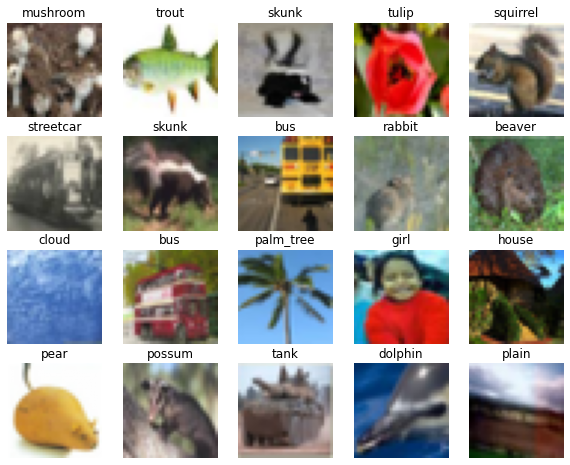

In [205]:
nrow = 4
ncol = 5
indices = np.random.choice(x_train.shape[0], nrow*ncol)
fig, ax = plt.subplots(nrow, ncol, figsize=(2*ncol, 2*nrow))
for i in range(nrow):
    for j in range(ncol):
        ind = indices[i*ncol + j]
        ax[i,j].imshow(x_train[ind])
        ax[i,j].set_title(classes[y_train[ind]])
        ax[i,j].axis('off')

___

# II. Classification d'images avec Keras

<a class='anchor' id='part2'></a>

Dans cette partie, on se propose d'implémenter un réseau convolutif pour la classification d'images avec [Keras](https://keras.io/).

**A noter :** la version 2.3.0 de [Keras](https://keras.io/), sortie le 17 septembre 2019, est la dernière. [Keras](https://keras.io/) est à présent complètement [intégré et maintenu](https://github.com/keras-team/keras/releases/tag/2.3.0) dans [TensorFlow](https://www.tensorflow.org/) 2.0, sorti le 30 septembre 2019.

Dans la suite, on se base donc principalement sur le module [Keras](https://keras.io/) de [TensorFlow](https://www.tensorflow.org/) 2.0.

In [25]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model

## Exercice n°1 : pré-traitement des données

<a class='anchor' id='exo1'></a>

Afin d'éviter l'explosion ou l'extinction de gradient, il convient de normaliser les pixels entre 0 et 1.

**Consigne :** normaliser les jeux de données `x_train` et `x_test` de manière à ce que chaque pixel soit entre 0 et 1. 

**Indice :** dans une image, chaque pixel est un nombre entier entre 0 et 255.

In [26]:
x_train = x_train/255
x_test = x_test/255

**Tests unitaires**

In [53]:
assert x_train.max() == 1
assert x_train.min() == 0
assert x_test.max() == 1
assert x_test.min() == 0
print('Très bien !')

Très bien !


## Exercice n°2 : pré-traitement des labels

<a class='anchor' id='exo2'></a>

La manière standard de représenter les labels pour un classification multi-classes est le *one-hot encoding*.

**Consigne :** transformer les labels `y_train` et `y_test` en matrices *one-hot*, avec autant de colonnes que de classes et des indicatrices 0 ou 1.

**Indice :** on pourra se baser sur la fonction [to_categorical](https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical).

In [56]:
y_train = to_categorical(y_train, len(classes))
y_test = to_categorical(y_test, len(classes))

**Tests unitaires**

In [29]:
assert y_train.shape == (50000, len(classes))
assert y_test.shape == (10000, len(classes))
print('Très bien !')

Très bien !


**A noter :** dans [Keras](https://keras.io/), on peut s'épargner cette transformation à condition d'utiliser une fonction de coût spécifique, la [sparse categorical cross-entropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/sparse_categorical_crossentropy).

## Exercice n°3 : construction d'un modèle convolutif

<a class='anchor' id='exo3'></a>

Dans cet exercice, on se propose d'implémenter un modèle convolutif couche par couche. La construction couche par couche est appelée construction séquentielle, par opposition aux constructions à plusieurs branches.

L'ordre des couches est déterminé par les observations suivantes :
* le temps de calcul est plus rapide quand la couche de regroupement (*pooling*) est placée avant l'activation, car l'activation du nombré zéro est toujours triviale,
* [l'expérience montre](https://blog.paperspace.com/busting-the-myths-about-batch-normalization/) que la couche de normalisation par batch (*batch normalization*) est plus efficace après l'activation.

### Etape 0

**Consigne :** instancier un objet `model` qui servira de base au réseau de neurones.

**Indice :** on pourra se baser sur le [sequential model](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential).

In [30]:
model = Sequential()

In [78]:
x_train.shape[1:]

(32, 32, 3)

### Etape 1

A présent, on se propose de réaliser une première couche du réseau, selon le motif suivant :

**COUCHE n°1 :** $CONV \rightarrow RELU \rightarrow BATCHNORM$

**Consigne :** ajouter au modèle une couche comprenant :
* une convolution $3\times 3$ avec 32 filtres et une régularisation $L^2$ avec pénalité de $0.01$
* une activation $ReLU$
* une normalisation par batch

**Indice :** on pourra se baser sur les couches [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) et [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization). On prendra également garde aux arguments `input_shape` et `use_bias` (mettre à `False`) de la couche convolutive.

**A noter :** dans [Keras](https://keras.io/), les images doivent être au format `channels_last` par défaut, comme pour [matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.imshow.html). Si ce n'est pas le cas, on peut changer l'option `data_format` dans les [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), et l'option `axis` dans la [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization). Encore faut-il s'en souvenir...

**Indice :** si besoin, n'hésitez pas à consulter [cet article de vulgarisation](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/) sur l'utilisation de CONV2D.

In [31]:
model.add(Conv2D(32, (3, 3), input_shape=x_train.shape[1:], use_bias=False, kernel_regularizer=l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())

**ATTENTION !** La partie qui suit va vous poser plusieurs questions pour vérifier votre compréhension des dimensions dans chaque type de couche !

Nous vous conseillons d'attendre **d'avoir lancé l'entraînement de votre modèle Keras** (car il va durer un moment) et de répondre à ces questions une fois l'entraînement lancé.



**Questions :**
Sachant que les images en entrée sont au format $32\times 32\times 3$ :
1. Quelle est la dimension des variables en sortie de la couche convolutive n°1 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) ? (**Indice :** par défault le padding est `same`)
2. Combien y a-t-il de paramètres apprenables pour cette couche ?
3. Quelle est la dimension des variables en sortie de la couche d'activation n°1 [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) ?
4. Combien y a-t-il de paramètres apprenables pour cette couche ?
5. Quelle est la dimension des variables en sortie de la couche de normalisation n°1 [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) ?
6. Combien y a-t-il de paramètres apprenables pour cette couche ?
7. Pourquoi a-t-on choisi de ne pas instancier de biais dans notre couche (`use_bias=False`)?

**Réponses :**
1. En l'absence de padding, $30\times 30\times 32$
2. Le noyau de convolution est de taille $3\times 3\times 3$ pour 32 filtres, d'où, en l'absence de biais, $3\times 3\times 3\times 32 = 864$
5. Aucune modification de dimension : $30\times 30\times 32$
6. Aucun paramètre à apprendre.
7. Aucune modification de dimension : $30\times 30\times 32$
8. Deux paramètres $\beta$ et $\gamma$ par filtre : $2\times 32 = 64$
7. Parce que le paramètre $\beta$ de la BatchNorm est redondant avec les biais, pas besoin donc d'en mettre.

### Etape 2

A présent, on se propose d'ajouter plusieurs couches au réseau, quasi-identiques à la première couche :

**COUCHE n°2 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°3 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°4 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

La différence réside uniquement dans la couche de regroupement (*pooling*).

**Consigne :** ajouter au modèle trois couches, chacune comprenant :
* une convolution $3\times 3$ avec 32 filtres et une régularisation $L^2$ avec pénalité de $0.01$
* un regroupement (*pooling*) $2\times 2$
* une activation $ReLU$
* une normalisation par batch

**Indice :** on pourra se baser sur les couches [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D), [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) et [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization). On prendra également garde à l'argument `use_bias` des couches convolutives comme à la question précédente.

**A noter :** comme pour les couches [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), la positions des canaux dans [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) est à spécifier avec l'option `data_format` si l'on travaille en `channels_first`.

In [32]:
model.add(Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(0.01)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Activation('relu'))
model.add(BatchNormalization())

**Questions :**
Sachant que les features en entrée sont au format $30\times 30\times 32$:
1. Quelle est la dimension des variables en sortie de la couche convolutive n°2 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) ?
2. Combien y a-t-il de paramètres apprenables pour cette couche ?
3. Quelle est la dimension des variables en sortie de la couche de regroupement n°2 [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) ?
4. Combien y a-t-il de paramètres apprenables pour la couche de normalisation n°2 [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) ?
5. Quelle est la dimension des variables en sortie de la couche convolutive n°3 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) ?
6. Combien y a-t-il de paramètres apprenables pour cette couche ?
7. Quelle est la dimension des variables en sortie de la couche de regroupement n°3 [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) ?
8. Combien y a-t-il de paramètres apprenables pour la couche de normalisation n°3 [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) ?
9. Quelle est la dimension des variables en sortie de la couche convolutive n°4 [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) ?
10. Combien y a-t-il de paramètres apprenables pour cette couche ?
11. Quelle est la dimension des variables en sortie de la couche de regroupement n°4 [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) ?
12. Combien y a-t-il de paramètres apprenables pour la couche de normalisation n°4 [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization) ?

**Réponses :**
1. L'entrée étant de dimension $30\times 30\times 32$, et en l'absence de padding, on obtient $28\times 28\times 32$
2. Le noyau de convolution est de taille $3\times 3\times 32$ pour 32 filtres, d'où, en l'absence de biais, $3\times 3\times 32\times 32 = 9216$
3. Le regroupement divise par deux le nombre de pixels dans chaque dimension : $14\times 14\times 32$
4. Deux paramètres $\beta$ et $\gamma$ par filtre : $2\times 32 = 64$

5. L'entrée étant de dimension $14\times 14\times 32$, et en l'absence de padding, on obtient $12\times 12\times 32$
6. Le noyau de convolution est de taille $3\times 3\times 32$ pour 32 filtres, d'où, en l'absence de biais, $3\times 7\times 32\times 32 = 9216$
7. Le regroupement divise par deux le nombre de pixels dans chaque dimension : $6\times 6\times 32$
8. Deux paramètres $\beta$ et $\gamma$ par filtre : $2\times 32 = 64$

5. L'entrée étant de dimension $6\times 6\times 32$, et en l'absence de padding, on obtient $4\times 4\times 32$
6. Le noyau de convolution est de taille $3\times 3\times 32$ pour 32 filtres, d'où, en l'absence de biais, $3\times 7\times 32\times 32 = 9216$
7. Le regroupement divise par deux le nombre de pixels dans chaque dimension : $2\times 2\times 32$
8. Deux paramètres $\beta$ et $\gamma$ par filtre : $2\times 32 = 64$

### Etape 3

En guise d'avant-dernière couche, on se propose d'aplatir la couche obtenue précédemment et de la brancher sur une couche dense avec *dropout* et activation $ReLU$.

**COUCHE n°5 :** $FLATTEN \rightarrow DENSE \rightarrow DROPOUT \rightarrow ReLU$

**Consigne :** ajouter au modèle une couche comprenant :
* un aplatissement
* une couche dense avec 128 neurones
* une régularisation dropout de paramètre $p=0.1$
* une activation $ReLU$

Ici on place la couche de dropout avant l'activation pour gagner en temps de calcul.

**Indice :** on pourra se baser sur les couches [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) et [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation).

In [33]:
model.add(Flatten())
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Activation('relu'))

**Question :** combien y a-t-il de paramètres apprenables dans cette couche ?

**Réponse :** 128 neurones et 1 biais en entrée pour 128 neurones en sortie, soit $129\times 128 = 16 512$

### Etape 4

Enfin, la dernière couche est la classification proprement dite, c'est-à-dire une couche dense activée via une fonction *softmax* :

**COUCHE n°6 :** $DENSE \rightarrow SOFTMAX$

**Consigne :** ajoute au modèle une couche comprenant :
* une couche dense avec autant de neurones que de classes à prédire
* une activation softmax

**Indice :** on pourra se baser sur les couches [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) et [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation).

In [34]:
model.add(Dense(len(classes)))
model.add(Activation('softmax'))

**Question :** combien y a-t-il de paramètres apprenables dans cette couche ?

**Réponse :** 128 neurones et 1 biais en entrée, pour 100 neurones en sortie, soit $129\times 100 = 12900$

**Astuce :** vous pouvez vérifier vos calculs via la méthode [summary](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary)

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        864       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 32)        1

## Exercice n°4 : entraînement du modèle convolutif

<a class='anchor' id='exo4'></a>

La première chose à faire est d'instancier l'algorithme d'optimisation.

**Consigne :** instancier un `optimizer` de type Adam avec un taux d'apprentissage de $0.001$.

**Indice :** on pour se baser sur  [Adam](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam).

In [36]:
adam = Adam(lr=0.001)

Ensuite, il s'agit de compiler le modèle.

**Consigne :** compiler le modèle avec :
* une fonction de coût `categorical_crossentropy`
* l'optimisateur Adam instancié précédemment
* une métrique `accuracy` affichée

**Indice :** on pourra se baser sur la méthode [compile](https://www.tensorflow.org/api_docs/python/tf/keras/Model#compile).

In [37]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

**Question :** Avez-vous déjà rencontré les deux fonctions de coût `CategoricalCrossentropy` et `SparseCategoricalCrossentropy` ? Connaissez-vous les différences entre les deux ?

**Réponse :** cela dépend de si vous encodez à chaud ou non vos labels.

- `CategoricalCrossentropy` est à utilisé si vos labels sont encodés,
- `SparseCategoricalCrossentropy` sinon.

Enfin, il s'agit d'entraîner le réseau de neurones sur le jeu d'entraînement.

**Consigne :** entraîner le réseau de neurones sur le jeu de données (`x_train`, `y_train`) avec :
* 256 images par batch tirées aléatoirement à chaque époque
* 20 époques d'entraînement
* un jeu de validation égal à (`x_test`, `y_test`)
* `verbose=1`
* on assignera la sortie de l'entraînement à la variable `history` afin de tracer la courbe d'apprentissage ultérieurement

**Indice :** on pourra se baser sur la méthode [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).

L'entraînement peut durer 20 minutes, c'est le moment de répondre aux questions précédentes si vous ne l'avez pas encore fait !

In [38]:
history = model.fit(
    x_train,
    y_train,
    batch_size=256,
    epochs=10,
    shuffle=True,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/10
196/196 [==============================] - 115s 585ms/step - loss: 4.6277 - accuracy: 0.1024 - val_loss: 5.5650 - val_accuracy: 0.0169
Epoch 2/10
196/196 [==============================] - 115s 584ms/step - loss: 3.6127 - accuracy: 0.2081 - val_loss: 5.3021 - val_accuracy: 0.0263
Epoch 3/10
196/196 [==============================] - 114s 583ms/step - loss: 3.1503 - accuracy: 0.2751 - val_loss: 3.8396 - val_accuracy: 0.1589
Epoch 4/10
196/196 [==============================] - 114s 584ms/step - loss: 2.8884 - accuracy: 0.3196 - val_loss: 2.8973 - val_accuracy: 0.3149
Epoch 5/10
196/196 [==============================] - 114s 583ms/step - loss: 2.7154 - accuracy: 0.3497 - val_loss: 2.7817 - val_accuracy: 0.3330
Epoch 6/10
196/196 [==============================] - 114s 583ms/step - loss: 2.6010 - accuracy: 0.3748 - val_loss: 2.7447 - val_accuracy: 0.3457
Epoch 7/10
196/196 [==============================] - 115s 585ms/step - loss: 2.5119 - accuracy: 0.3903 - val_loss: 2.6285 -

On peut alors tracer la courbe d'apprentissage, c'est-à-dire la performance sur le jeu d'entraînement et de validation pendant l'apprentissage. Sur [ce blog](https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-5-cifar-100-a557e19219ba), on trouvera le détail d'une architecture permettant d'obtenir 75% d'exactitude sur le jeu de test. Pour information, l'état de l'art de la performance sur CIFAR-100 est [disponible en ligne](https://paperswithcode.com/sota/image-classification-on-cifar-100). Quant à la performance humaine, elle avoisine [90 %](https://arxiv.org/pdf/1811.07270.pdf).

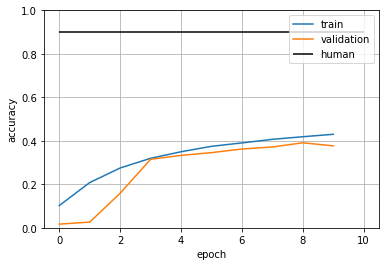

In [39]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.hlines(0.9, 0, 10, label='human')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(loc='best')
plt.grid();

**Questions :** 
1. Au vu de la courbe d'apprentissage, pensez-vous que le modèle est à fort biais ou à forte variance ?
2. Quelles pistes d'amélioration envisagez-vous ?

**Réponses :**
1. En premier lieu, la performance du modèle sur le jeu d'entraînement est toujours éloignée de la performance humaine, laissant présager un sous-apprentissage.

2. Il y a encore beaucoup de marge sur le jeu d'entraînement, il faudrait donc complexifier le modèle :

    * en l'entraînant plus longtemps (100 époques est courant)
    * en augmentant le nombre de filtres des couches convolutives (plusieurs centaines est courant)
    * en rajoutant des couches convolutives (plusieurs dizianes est courant)
    * en explorant des architectures plus souples (inception)
    * en explorant des architectures plus profondes (ResNet)
    
Une fois la performance humaine atteinte sur le jeu d'entraînement, on pourrait alors commencer à régulariser le réseau pour faire monter la performance sur le jeu de validation.

## Exercice n°5 : prédiction sur le jeu de test

<a class='anchor' id='exo5'></a>

Maintenant que le modèle est entraîné, on peut évaluer la performance sur le jeu de test.

**Consigne :** récupérer dans la variable `y_pred` les prédictions du modèle sur le jeu de test `x_test`.

**Indice :** on pourra se baser sur la méthode [predict](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict).

In [103]:
y_pred = model.predict(x_test)

**Question :** quelle est la dimension de `y_pred` ?

In [104]:
y_pred.shape

(10000, 100)

**Question :** comment vérifier que la somme des scores pour chaque ligne vaut bien 1 ?

In [105]:
s = y_pred.sum(axis=1)
s.min(), s.max()

(0.9999996, 1.0000004)

**Question :** comment obtenir le numéro de la *vraie* 
classe sur `y_test`? 

In [ ]:
y_test = y_test.argmax(axis=1)

**Question :** comment obtenir le numéro de la classe *prédite* sur `y_pred` ?

In [107]:
y_pred = y_pred.argmax(axis=1)

**Question :** quelle est l'exactitude (*accuracy*) du modèle sur le jeu de test ?

In [108]:
(y_test == y_pred).sum()/len(y_test)

0.3769

## Exercice n°6 : analyse d'erreurs

<a class='anchor' id='exo6'></a>

Dans cette exercice, on va essayer de compter le taux d'erreurs pour chaque classe séparément, de manière à comprendre si certaines classes sont plus faciles à prédire que d'autres et pourquoi. Cela revient à calculer une matrice de confusion tenant compte de toutes les possibilités.

**Consigne :** calculer la matrice de confusion qui comptabilise toutes les réponses prédites eu égard aux vrais labels.

**Indice :** on pourra se baser sur [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [109]:
cm = confusion_matrix(y_test, y_pred)

**Consigne :** extraire la diagonale `count` de la matrice de confusion afin de ne récupérer que les comptes de prédictions justes.

**Indice :** on pourra se baser sur [numpy.diag](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html).

In [110]:
count = np.diag(cm)

**Consigne :** compter le nombre d'observations `total` pour chaque label.

**Indice :** on pourra se baser sur [numpy.bincount](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html).

In [111]:
total = np.bincount(y_test)

**Consigne :** en déduire le pourcentage `percent` de bonnes réponses classe par classe.

**Indice :** on pourra utiliser les variables `count` et `total` précédentes.

In [112]:
percent = count/total

**Consigne :** pour chaque classe, imprimer le pourcentage de bonne réponse en ordre croissant.

**Indice :** on pourra appliquer [enumerate](https://docs.python.org/3/library/functions.html#enumerate) sur la variables `classes` pour interroger le résultat précédent `percent`.

In [124]:
for i, name in enumerate(classes):
  if i<=10:
    print("Accuracy of {}: {}".format(name, percent[i]))

Accuracy of apple: 0.53
Accuracy of aquarium_fish: 0.66
Accuracy of baby: 0.2
Accuracy of bear: 0.2
Accuracy of beaver: 0.05
Accuracy of bed: 0.26
Accuracy of bee: 0.52
Accuracy of beetle: 0.41
Accuracy of bicycle: 0.51
Accuracy of bottle: 0.52
Accuracy of bowl: 0.34


In [125]:
class_accuracy = []

for i, name in enumerate(classes):
  class_accuracy.append((name, percent[i]))

class_accuracy.sort(key=lambda x:x[1])
class_accuracy

[('seal', 0.01),
 ('beaver', 0.05),
 ('mouse', 0.06),
 ('girl', 0.07),
 ('otter', 0.09),
 ('possum', 0.1),
 ('man', 0.14),
 ('raccoon', 0.14),
 ('woman', 0.14),
 ('house', 0.15),
 ('kangaroo', 0.15),
 ('squirrel', 0.16),
 ('snake', 0.17),
 ('tulip', 0.17),
 ('baby', 0.2),
 ('bear', 0.2),
 ('boy', 0.2),
 ('lobster', 0.2),
 ('clock', 0.21),
 ('camel', 0.22),
 ('pine_tree', 0.22),
 ('train', 0.22),
 ('turtle', 0.22),
 ('lamp', 0.23),
 ('lizard', 0.23),
 ('rabbit', 0.23),
 ('snail', 0.24),
 ('bus', 0.25),
 ('shrew', 0.25),
 ('bed', 0.26),
 ('couch', 0.26),
 ('wolf', 0.26),
 ('cattle', 0.27),
 ('bridge', 0.28),
 ('crab', 0.29),
 ('elephant', 0.29),
 ('flatfish', 0.29),
 ('fox', 0.29),
 ('leopard', 0.29),
 ('butterfly', 0.3),
 ('mushroom', 0.3),
 ('rose', 0.3),
 ('table', 0.31),
 ('whale', 0.31),
 ('forest', 0.32),
 ('porcupine', 0.32),
 ('telephone', 0.32),
 ('poppy', 0.33),
 ('bowl', 0.34),
 ('dinosaur', 0.35),
 ('keyboard', 0.37),
 ('shark', 0.37),
 ('television', 0.37),
 ('chimpanzee', 0

___
# III. Classification d'images avec TensorFlow

<a class='anchor' id='part3'></a>

Dans cette partie, on se propose d'implémenter un réseau convolutif pour la classification d'images avec [TensorFlow](https://www.tensorflow.org/).

**A noter :** depuis le 30 septembre 2019, [TensorFlow](https://www.tensorflow.org/) 2.0 intègre nativement l'API [Keras](https://keras.io/). Cette dernière est même élevée au rang d'API standard de [TensorFlow](https://www.tensorflow.org/) 2.0. Dans la suite, on intègre donc naturellement certains modules [Keras](https://keras.io/). La différence avec la partie précédente réside principalement dans :
* la gestion des jeux de données
* l'instanciation d'une classe `TFModel`
* la phase d'apprentissage et de prédiction batch par batch

In [126]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Activation, MaxPool2D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

## Exercice n°7 : pré-traitement des données

<a class='anchor' id='exo7'></a>

Afin d'éviter l'explosion ou l'extinction de gradient, il convient de normaliser les pixels entre 0 et 1.

Ici, il n'y a rien à faire car la normalisation a déjà été faite dans la partie précédente !

In [127]:
if x_train.max() == 255:
    x_train = x_train/255
if x_test.max() == 255:
    x_test = x_test/255

**Tests unitaires**

In [128]:
assert x_train.max() == 1
assert x_train.min() == 0
assert x_test.max() == 1
assert x_test.min() == 0
print('Très bien !')

Très bien !


Pour les labels, nous n'allons pas utiliser d'encodage *one-hot* dans cette partie.

In [129]:
if len(y_train.shape) == 2 and y_train.shape[1] == len(classes):
    y_train = y_train.argmax(axis=1)
if len(y_train.shape) == 2 and y_train.shape[1] == len(classes):
    y_train = y_train.argmax(axis=1)

**Tests unitaires**

In [130]:
assert y_train.shape == (50000,)
assert y_test.shape == (10000,)
print('Très bien !')

Très bien !


## Exercice n°8 : chargement des données au fur et à mesure

<a class='anchor' id='exo8'></a>

Dans cet exercice, on instancie des *dataloaders* qui permettent d'extraire des images du jeu de données au fur et à mesure. En particulier, ils permettent d'économiser de la mémoire, puisque le jeu de données n'est jamais lu en entier, seul le batch courant est disponible.

Pour charger les données, on fait appel à un *loader* de données.

### Jeu d'entraînement

**Consigne :** instancier `trainloader`, un chargeur de données du jeu d'entraînement. Les données seront chargées de manière aléatoire par batch de 256 images. Le buffer de sélection aléatoire sera de taille 10 000.

**Indice :** on pourra se baser sur [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) et le jeu d'entraînement `x_train`, `y_train`. Les méthodes [from_tensor_slices](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices), [shuffle](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle) et [batch](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#batch) peuvent être utiles.

In [131]:
x_train.shape

(50000, 32, 32, 3)

In [133]:
trainloader = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)
)\
.shuffle(10000)\
.batch(256)

In [160]:
print("Type de trainloader : {}".format(type(trainloader)))
print("Longueur de notre dataloader : {} batches de 256 éléments".format(len(list(trainloader.as_numpy_iterator()))))
print("Chaque élément du dataloader est un {} de longueur {}"\
      .format(type(list(trainloader.as_numpy_iterator())[0]), len(list(trainloader.as_numpy_iterator())[0])))
print("Le premier élément est un {} de dimension {}, nos data"\
      .format(type(list(trainloader.as_numpy_iterator())[0][0]), list(trainloader.as_numpy_iterator())[0][0].shape))
print("Le deuxième élément est un {} de dimension {}, nos labels"\
      .format(type(list(trainloader.as_numpy_iterator())[0][1]), list(trainloader.as_numpy_iterator())[0][1].shape))


Type de trainloader : <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Longueur de notre dataloader : 196 batches de 256 éléments
Chaque élément du dataloader est un <class 'tuple'> de longueur 2
Le premier élément est un <class 'numpy.ndarray'> de dimension (256, 32, 32, 3), nos data
Le deuxième élément est un <class 'numpy.ndarray'> de dimension (256,), nos labels


### Jeu de test

**Consigne :** instancier un `testloader` à partir de `x_test`, `y_test`.

**Indice :** on pourra reproduire la syntaxe obtenue pour le `train`, sans le `shuffle`.

In [161]:
testloader = tf.data.Dataset.from_tensor_slices(
    (x_test, y_test)
)\
.batch(256)

In [162]:
print("Type de testloader : {}".format(type(testloader)))
print("Longueur de notre dataloader : {} batches de 256 éléments".format(len(list(testloader.as_numpy_iterator()))))
print("Chaque élément du dataloader est un {} de longueur {}"\
      .format(type(list(testloader.as_numpy_iterator())[0]), len(list(testloader.as_numpy_iterator())[0])))
print("Le premier élément est un {} de dimension {}, nos data"\
      .format(type(list(testloader.as_numpy_iterator())[0][0]), list(testloader.as_numpy_iterator())[0][0].shape))
print("Le deuxième élément est un {} de dimension {}, nos labels"\
      .format(type(list(testloader.as_numpy_iterator())[0][1]), list(testloader.as_numpy_iterator())[0][1].shape))


Type de testloader : <class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>
Longueur de notre dataloader : 40 batches de 256 éléments
Chaque élément du dataloader est un <class 'tuple'> de longueur 2
Le premier élément est un <class 'numpy.ndarray'> de dimension (256, 32, 32, 3), nos data
Le deuxième élément est un <class 'numpy.ndarray'> de dimension (256,), nos labels


## Exercice n°9 : construction d'un modèle convolutif 

<a class='anchor' id='exo9'></a>

Dans cet exercice, on se propose de reproduire l'architecture précédente :

**COUCHE n°1 :** $CONV \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°2 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°3 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°4 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°5 :** $FLATTEN \rightarrow DENSE \rightarrow DROPOUT \rightarrow ReLU$

**COUCHE n°6 :** $DENSE \rightarrow SOFTMAX$

* Chaque couche convolutive possède :
    * une convolution $3\times 3$ avec 32 filtres et une régularisation $L^2$ avec pénalité de $0.01$
    * une activation $ReLU$
* Chaque couche de regroupement possède :
    * un filtre de taille $2\times 2$
* La première couche dense possède :
    * 128 neurones
    * un dropout de paramètre $p=0.1$
    * une activation $ReLU$
* La dernière couche dense possède :
    * 100 neurones (le nombre de classes à prédire)
    * un activation softmax

Dans [TensorFlow](https://www.tensorflow.org/), instancier un modèle se fait par héritage de la classe [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model).

**Consigne :** créer une classe `TFModel` héritant de [Model](https://www.tensorflow.org/api_docs/python/tf/keras/Model), contenant :
* une fonction `__init__` qui appelera le constructeur de la classe parent `super().__init__()` et définira toutes les couches nécessaires comme des attributs de classe
* une fonction `call` qui prend en entrée un batch de données `x` et renvoie en sortie le résultat de la dernière couche. 

**Indice :** on pourra se baser sur les couches [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D), [MaxPool2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D), [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten), [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense), [Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout), [Activation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Activation) et [BatchNormalization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization). On prendra également garde aux arguements `use_bias` des couches convolutives. Pour l'héritage de la classe `Model`, on peut penser à regarder, par exemple, [cette source](https://www.pyimagesearch.com/2019/10/28/3-ways-to-create-a-keras-model-with-tensorflow-2-0-sequential-functional-and-model-subclassing/).

In [164]:
class TFModel(Model):
    
    def __init__(self):
        super().__init__()
        self.conv1 = Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(0.01))
        self.act1 = Activation('relu')
        self.bn1 = BatchNormalization()
        
        self.conv2 = Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(0.01))
        self.pool2 = MaxPool2D(pool_size=(2, 2))
        self.act2 = Activation('relu')
        self.bn2 = BatchNormalization()
       
        self.conv3 = Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(0.01))
        self.pool3 = MaxPool2D(pool_size=(2, 2))
        self.act3 = Activation('relu')
        self.bn3 = BatchNormalization()
       
        self.conv4 = Conv2D(32, (3, 3), use_bias=False, kernel_regularizer=l2(0.01))
        self.pool4 = MaxPool2D(pool_size=(2, 2))
        self.act4 = Activation('relu')
        self.bn4 = BatchNormalization()
       
        self.flat5 = Flatten()
        self.fc5 = Dense(128)
        self.drop5 = Dropout(0.1)
        self.act5 = Activation('relu')
       
        self.fc6 = Dense(len(classes))
        self.act6 = Activation('softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.act2(x)
        x = self.bn2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = self.act3(x)
        x = self.bn3(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = self.act4(x)
        x = self.bn4(x)
        
        x = self.flat5(x)
        x = self.fc5(x)
        x = self.drop5(x)
        x = self.act5(x)
        
        x = self.fc6(x)
        x = self.act6(x)
        return x

Une fois la classe `TFModel` définie, on peut en créer une instance `model`.

In [167]:
model = TFModel()

Avant d'en sonder l'architecture, il faut préciser la forme des entrées à l'aide de la méthode [`build`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer)

In [170]:
model.build((None, x_train.shape[1], x_train.shape[2], x_train.shape[3]))

On peut vérifier notre architecture avec [summary](https://www.tensorflow.org/api_docs/python/tf/keras/Model#summary).

In [171]:
model.summary()

Model: "tf_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            multiple                  864       
_________________________________________________________________
activation_12 (Activation)   multiple                  0         
_________________________________________________________________
batch_normalization_8 (Batch multiple                  128       
_________________________________________________________________
conv2d_9 (Conv2D)            multiple                  9216      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
activation_13 (Activation)   multiple                  0         
_________________________________________________________________
batch_normalization_9 (Batch multiple                  1

## Exercice n°10 : entraînement du modèle convolutif

<a class='anchor' id='exo10'></a>

A présent, il faut définir la fonction de coût et l'algorithme d'optimisation.

**Consigne :** instancier un `criterion` qui calcule la fonction de coût.

**Indice :** on pourra se baser sur  la classe [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), qui ne nécessite pas de *one-hot encoding* de la cible.

In [172]:
criterion = tf.keras.losses.SparseCategoricalCrossentropy()

**Consigne :** instancier un `optimizer` de type Adam avec un taux d'apprentissage de $0.001$ et une pénalité L2 de 0.01.

**Indice :** on pourra se baser sur la classe [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [173]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

On souhaite également calculer la fonction de coût moyenne par époque ainsi que l'exactitude des prédictions.

**Consigne :** instancer `train_loss` et `train_accuracy`.

**Indice :** on pourra se baser sur [Mean](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Mean) et
[SparseCategoricalAccuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy). Le moyennage batch par batch via [Mean](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Mean) n'est pas nécessaire pour l'exactitude, qui contient déjà une mécanique interne de mise à jour de la moyenne.

In [174]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

**Consigne :** instancer `test_loss` et `test_accuracy`.

**Indice :** on pourra se baser sur [Mean](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Mean) et
[SparseCategoricalAccuracy](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy). Le moyennage batch par batch via [Mean](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/Mean) n'est pas nécessaire pour l'exactitude, qui contient déjà une mécanique interne de mise à jour de la moyenne.

In [175]:
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

### Evaluer le modèle après chaque batch

Contrairement à [Keras](https://keras.io/), [TensorFlow](https://www.tensorflow.org/) ne permet pas de calculer automatiquement une métrique de performance sur le jeu d'entraînement ou de validation. Il faut donc implémenter la fonction soi-même.

**Consigne :** compléter la fonction `evaluate_step` suivante :
* elle prend en entrée un batch `x_batch`, `y_batch`, un `model`, un `criterion`, un `test_loss` et un `test_accuracy`.

**Indice :** il suffit d'appeler dans l'ordre `model`, `criterion`, `test_loss` et `test_accuracy`.

In [176]:
@tf.function
def evaluate_step(x_batch, y_batch, model, criterion, test_loss, test_accuracy):
    """
    Evaluate a model on a batch of testing data.
    
    Parameters
    ----------
    x_batch: tensor
        Batch of input features.
    y_batch: tensor
        Batch of input labels.
    model: tensorflow model
        Model to evaluate.
    criterion: tensorflow loss function
        Loss function to evaluate.
    test_loss: tensorflow metrics
        Loss function to update.
    test_accuracy: tensorflow metrics
        Accuracy to update.
    """
    s_batch = model(x_batch)
    t_loss = criterion(y_batch, s_batch)
    test_loss(t_loss)
    test_accuracy(y_batch, s_batch)

### Entraîner le modèle batch par batch

Pour l'entraînement, c'est l'utilisateur qui doit préciser les différentes étapes.

**Consigne :** compléter la fonction `train_step` suivante :
* elle prend en entrée un batch `x_batch`, `y_batch`, un `model`, un `criterion`, un `optimizer`, un `train_loss` et un `train_accuracy`.

**Indice :** on contextualisera les calculs avec un [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape) comme suit :

```
with tf.GradientTape() as tape:
    s_batch = model(x_batch)                                            # calcul de la dernière couche
    loss = criterion(y_batch, s_batch)                                  # calcul de la fonction de coût
gradients = tape.gradient(loss, model.trainable_variables)              # calcul des gradients
optimizer.apply_gradients(zip(gradients, model.trainable_variables))    # mise à jour des gradients
```
Cela permet à [TensorFlow](https://www.tensorflow.org/) d'effectuer une différenciation automatique lors de la propagation en avant pour le calcul de gradient. On appliquera ensuite la méthode [gradient](https://www.tensorflow.org/api_docs/python/tf/GradientTape#gradient) avec comme arguments `loss`, le coût courant (cf code ci-dessus), et `model.trainable_variables`, les poids du réseau de neurones. Quant à la mise à jour des poids, elle se fera via la méthode [apply_gradients](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Optimizer#apply_gradients) de l'optimizer. 

In [177]:
@tf.function
def train_step(x_batch, y_batch, model, criterion, optimizer, train_loss, train_accuracy):
    """
    Train a model on a batch of training data.
    
    Parameters
    ----------
    x_batch: tensor
        Batch of input features.
    y_batch: tensor
        Batch of input labels.
    model: tensorflow model
        Model to train.
    criterion: tensorflow loss function
        Loss function to evaluate.
    optimizer: tensorflow optimizer
        Optimization algorithm to update.
    train_loss: tensorflow metrics
        Loss function to compute.
    train_accuracy: tensorflow metrics
        Accuracy to update.
    """
    with tf.GradientTape() as tape:
        s_batch = model(x_batch)
        loss = criterion(y_batch, s_batch)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_batch, s_batch)

### Entraînement du modèle

A présent, on peut utiliser ces deux fonctions pour entraîner le modèle plusieurs époques durant.

**Consigne :** Entraîner le modèle sur 10 époques grâce à la fonction `train_step`. On gardera en mémoire l'`accuracy` d'entraînement et de validation dans deux listes `train_history` et `test_history`. On calculera également le temps de calcul nécessaire pour chaque époque. Chaque époque imprimera 
* le numéro de l'époque
* la `loss` d'entraînement et de validation
* l'`accuracy` d'entraînement et de validation
* le temps de calcul

**Indice :** on pourra se baser sur [time.time](https://docs.python.org/3/library/time.html#time.time) pour le chronométrage. Le `dataloader` peut être interrogé comme suit :
```
for batch, labels in dataloader:
    do_something()
```
A la fin de chaque époque, on appliquera la méthode [reset_states](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/SparseCategoricalAccuracy#reset_states) pour les `loss` et `accuracy`, afin de ne pas mélanger les résultats.

In [178]:
train_history = []
test_history = []

for epoch in range(10):
    
    start = time.time()
    
    for x_batch, y_batch in trainloader:
        train_step(x_batch, y_batch, model, criterion, optimizer, train_loss, train_accuracy)
    train_history.append(train_accuracy.result())
    
    for x_batch, y_batch in testloader:
        evaluate_step(x_batch, y_batch, model, criterion, test_loss, test_accuracy)
    test_history.append(test_accuracy.result())
    
    end = time.time()   
    
    template = 'epoch {}, loss: {:.2f}, val_loss: {:.2f}, train_accuracy: {:.2f}, val_accuracy: {:.2f}, computing time: {:.2f}s'
    print(
        template.format(
            epoch + 1,
            train_loss.result(),
            test_loss.result(),
            train_accuracy.result(),
            test_accuracy.result(),
            end - start
        )
    )
    
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    
print('Finished Training')


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

epoch 1, loss: 4.22, val_loss: 3.85, train_accuracy: 0.06, val_accuracy: 0.11, computing time: 119.94s
epoch 2, loss: 3.68, val_loss: 3.51, train_accuracy: 0.14, val_accuracy: 0.17, computing time: 115.48s
epoch 3, loss: 3.41, val_loss: 3.37, train_accuracy: 0.18, val_accuracy: 0.20, computing time: 114.77s
epoch 4, loss: 3.25, val_loss: 3.23, train_accuracy: 0.22, val_accuracy: 0.22, computing time: 113.85s
epoch 5, loss: 3.10, val_loss: 3.09, train_accuracy: 0.24, val_accuracy: 0.25, computing time: 1

On peut alors tracer la courbe d'apprentissage, c'est-à-dire la performance sur le jeu d'entraînement et de validation pendant l'apprentissage. Sur [ce blog](https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-5-cifar-100-a557e19219ba), on trouvera le détail d'une architecture permettant d'obtenir 75% d'exactitude sur le jeu de test. Pour information, l'état de l'art de la performance sur CIFAR-100 est [disponible en ligne](https://paperswithcode.com/sota/image-classification-on-cifar-100). Quant à la performance humaine, elle avoisine [90 %](https://arxiv.org/pdf/1811.07270.pdf).

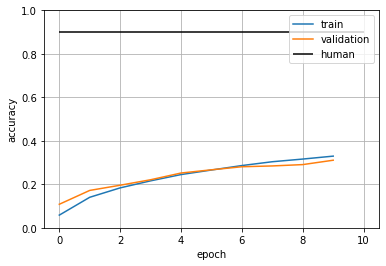

In [181]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='validation')
plt.hlines(0.9, 0, 10, label='human')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(loc='best')
plt.grid();

**Question :** quelles différences entre l'implémentation [Keras](https://keras.io/) et l'implémentation [TensorFlow](https://www.tensorflow.org/) ?

**Réponse :** les temps de calculs sont à peu près les mêmes, et les performances également. La différence réside essentiellement dans la syntaxe. [Keras](https://keras.io/) est plus facile à prendre en main, tandis que [TensorFlow](https://www.tensorflow.org/) est plus bas niveau et laisse toute la flexibilité à l'utilisateur.

## Exercice n°11 : prédiction sur le jeu de test

<a class='anchor' id='exo11'></a>

Maintenant que le modèle est entraîné, on peut évaluer la performance sur le jeu de test.

**Consigne :** agréger `y_test` et `y_pred` sur tout le jeu de test.

**Indice :** on pourra s'inspirer de la fonction `evaluate_step` précédente. Les résultats seront rangés dans des tableaux numpy, initialisés via [numpy.empty](https://docs.scipy.org/doc/numpy/reference/generated/numpy.empty.html) et cumulés via [numpy.concatenate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html). De plus, [TensorFlow](https://www.tensorflow.org/) offre la méthode [numpy](https://www.tensorflow.org/tutorials/customization/basics#numpy_compatibility) qui permet de convertir un tenseur en tableau.

In [ ]:
y_test = np.array([], dtype=int)
y_pred = np.empty((0, len(classes)), dtype=int)
for x_batch, y_batch in testloader:
    s_batch = model(x_batch)
    y_test = np.concatenate((y_test, y_batch.numpy()))
    y_pred = np.concatenate((y_pred, s_batch.numpy()))

**Question :** quelle est la dimension de `y_pred` ?

In [ ]:
y_pred.shape

(10000, 100)

**Question :** est-ce que la somme des scores pour chaque ligne vaut bien 1 ?

In [ ]:
s = y_pred.sum(axis=1)
s.min(), s.max()

(0.9999996700660485, 1.000000357165879)

**Question :** comment obtenir le numéro de la classe sur `y_test`? 

**Réponse :** contrairement à [Keras](https://keras.io/), il n'y a rien à faire, les labels n'ont pas subi de *one-hot encoding*.

**Question :** comment obtenir le numéro de la classe prédite sur `y_pred` ?

In [ ]:
y_pred = y_pred.argmax(axis=1)

**Question :** quelle est l'exactitude (*accuracy*) du modèle sur le jeu de test ?

In [ ]:
(y_test == y_pred).sum()/len(y_test)

0.3006

## Exercice n°12 : analyse d'erreurs

<a class='anchor' id='exo12'></a>

Dans cette exercice, on va essayer de compter le taux d'erreurs pour chaque classe séparément, de manière à comprendre si certaines classes sont plus faciles à prédire que d'autres et pourquoi. Cela revient à calculer une matrice de confusion tenant compte de toutes les possibilités.

**Consigne :** calculer la matrice de confusion qui comptabilise toutes les réponses prédites eu égard aux vrais labels.

**Indice :** on pourra se baser sur [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [96]:
cm = confusion_matrix(y_test, y_pred)

**Consigne :** extraire la diagonale `count` de la matrice de confusion afin de ne récupérer que les comptes de prédictions justes.

**Indice :** on pourra se baser sur [numpy.diag](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html).

In [97]:
count = np.diag(cm)

**Consigne :** compter le nombre d'observations `total` pour chaque label.

**Indice :** on pourra se baser sur [numpy.bincount](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html).

In [ ]:
total = np.bincount(y_test)

**Consigne :** en déduire le pourcentage `percent` de bonnes réponses classe par classe.

**Indice :** on pourra utiliser les variables `count` et `total` précédentes.

In [98]:
percent = count/total

**Consigne :** pour chaque classe, imprimer le pourcentage de bonne réponse.

**Indice :** on pourra appliquer [enumerate](https://docs.python.org/3/library/functions.html#enumerate) sur la variables `classes` pour interroger le résultat précédent `percent`.

In [ ]:
for i, name in enumerate(classes):
    print('i: {}, name: {}, Accuracy of {}: {}'.format(i, name, name, percent[i]))

___
# IV. Classification d'images avec PyTorch

<a class='anchor' id='part4'></a>

Dans cette partie, on se propose de construire la même architecture que précédemment avec la librairie [PyTorch](https://pytorch.org/).

In [182]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

## Exercice n°13 : chargement des données au fur et à mesure

<a class='anchor' id='exo13'></a>

Dans cet exercice, on instancie des *dataloaders* qui permettent d'extraire des images du jeu de données au fur et à mesure. En particulier, ils permettent d'économiser de la mémoire, puisque le jeu de données n'est jamais lu en entier, seul le batch courant est disponible.

### Conversion en tenseur

Les images doivent d'abord être converties en tenseur [PyTorch](https://pytorch.org/). La conversion opère déjà la normalisation sur les pixels (division par 255).

**Consigne :** créer un transformeur `transform` capable de convertir en tenseur [PyTorch](https://pytorch.org/) un batch d'images.

**Indice :** on pourra se baser sur [ToTensor](https://pytorch.org/docs/stable/torchvision/transforms.html#torchvision.transforms.ToTensor).

In [183]:
transform = transforms.ToTensor()

### Jeu d'entraînement

**Consigne :** instancier le jeu d'entraînement `training_set` sous forme d'un objet `torchvision.datasets.cifar.CIFAR100`.

**Indice :** on pourra se baser sur [torchvision.datasets.CIFAR100](https://pytorch.org/docs/stable/torchvision/datasets.html#cifar) en utilisant le transformeur `transform` précédent.

In [187]:
training_set = torchvision.datasets.CIFAR100(
    root='./datasets', 
    train=True,
    download=True,
    transform=transform
)

Extracting ./datasets/cifar-100-python.tar.gz to ./datasets


Pour charger les données, on fait appel à un *loader* de données.

**Consigne :** instancier `trainloader`, un chargeur de données du jeu d'entraînement. Les données seront chargées de manière aléatoire par batch de 256 images.

**Indice :** on pourra se baser sur [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) et le jeu d'entraînement `train`.

In [188]:
trainloader = torch.utils.data.DataLoader(
    training_set,
    batch_size=256,
    shuffle=True,
)

### Jeu de test

**Consigne :** instancier un `testing_set` et un `testloader` avec les mêmes propriétés que précédemment.

**Indice :** on pourra reproduire la syntaxe obtenue pour le `train`.

In [189]:
testing_set = torchvision.datasets.CIFAR100(
    root='./datasets', 
    train=False,
    download=True, 
    transform=transform
)

Files already downloaded and verified


In [190]:
testloader = torch.utils.data.DataLoader(
    testing_set, 
    batch_size=256,
    shuffle=False, 
)

## Exercice n°14 : construction d'un modèle convolutif 

<a class='anchor' id='exo14'></a>

Dans cet exercice, on se propose de reproduire l'architecture précédente :

**COUCHE n°1 :** $CONV \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°2 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°3 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°4 :** $CONV \rightarrow POOL \rightarrow RELU \rightarrow BATCHNORM$

**COUCHE n°5 :** $FLATTEN \rightarrow DENSE \rightarrow DROPOUT \rightarrow ReLU$

**COUCHE n°6 :** $DENSE \rightarrow SOFTMAX$

* Chaque couche convolutive possède :
    * une convolution $3\times 3$ avec 32 filtres et une régularisation $L^2$ avec pénalité de $0.01$
    * une activation $ReLU$
* Chaque couche de regroupement possède :
    * un filtre de taille $2\times 2$
* La première couche dense possède :
    * 128 neurones
    * un dropout de paramètre $p=0.1$
    * une activation $ReLU$
* La dernière couche dense possède :
    * 100 neurones (le nombre de classes à prédire)
    * un activation softmax

Dans [PyTorch](https://pytorch.org/), instancier un modèle se fait par héritage de la classe [Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module).

**Consigne :** créer une classe `Model` héritant de [nn.Module](https://pytorch.org/docs/stable/nn.html#torch.nn.Module), contenant :
* une fonction `__init__` qui appelera le constructeur de la classe parent `super().__init__()` et définira toutes les couches nécessaires comme des attributs de classe
* une fonction `forward` qui prend en entrée un batch de données `x` et renvoie en sortie le résultat de la dernière couche. 

**Indice :** on pourra se baser sur les méthodes [conv2d](https://pytorch.org/docs/stable/nn.html#conv2d), [maxpool2d](https://pytorch.org/docs/stable/nn.html#maxpool2d), [batchnorm2d](https://pytorch.org/docs/stable/nn.html#batchnorm2d), [relu](https://pytorch.org/docs/stable/nn.functional.html#relu), [linear](https://pytorch.org/docs/stable/nn.html#linear) et [view](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view). On prendre garde  à l'argument `bias` des couches convolutives.

In [191]:
class PTModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 32, 3, bias=False)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.bn2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32, 32, 3, bias=False)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.bn3 = nn.BatchNorm2d(32)
        
        self.conv4 = nn.Conv2d(32, 32, 3, bias=False)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.bn4 = nn.BatchNorm2d(32)
        
        self.fc5 = nn.Linear(128, 128)
        self.drop5 = nn.Dropout(0.1)
        
        self.fc6 = nn.Linear(128, len(classes))

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.bn1(x)
        
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.bn2(x)
        
        x = self.conv3(x)
        x = self.pool3(x)
        x = F.relu(x)
        x = self.bn3(x)
        
        x = self.conv4(x)
        x = self.pool4(x)
        x = F.relu(x)
        x = self.bn4(x)
        
        x = x.view(-1, 128)
        x = self.fc5(x)
        x = self.drop5(x)
        x = F.relu(x)
        
        x = self.fc6(x)
        return x

Une fois la classe `Model` définie, on peut en créer une instance `model`.

In [192]:
model = PTModel()

On peut vérifier notre architecture avec [torchsummary](https://github.com/sksq96/pytorch-summary).

In [193]:
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
       BatchNorm2d-2           [-1, 32, 30, 30]              64
            Conv2d-3           [-1, 32, 28, 28]           9,216
         MaxPool2d-4           [-1, 32, 14, 14]               0
       BatchNorm2d-5           [-1, 32, 14, 14]              64
            Conv2d-6           [-1, 32, 12, 12]           9,216
         MaxPool2d-7             [-1, 32, 6, 6]               0
       BatchNorm2d-8             [-1, 32, 6, 6]              64
            Conv2d-9             [-1, 32, 4, 4]           9,216
        MaxPool2d-10             [-1, 32, 2, 2]               0
      BatchNorm2d-11             [-1, 32, 2, 2]              64
           Linear-12                  [-1, 128]          16,512
          Dropout-13                  [-1, 128]               0
           Linear-14                  [

## Exercice n°15 : entraînement du modèle convolutif

<a class='anchor' id='exo15'></a>

A présent, il faut définir la fonction de coût et l'algorithme d'optimisation.

**Consigne :** instancier un `criterion` qui calcule la fonction de coût.

**Indice :** on pourra se baser sur  la classe [CrossEntropyLoss](https://pytorch.org/docs/stable/nn.html#crossentropyloss).

In [194]:
criterion = nn.CrossEntropyLoss()

**Consigne :** instancier un `optimizer` de type Adam avec un taux d'apprentissage de $0.001$ et une pénalité L2 de 0.01.

**Indice :** on pourra se baser sur la classe [Adam](https://pytorch.org/docs/stable/optim.html#torch.optim.Adam).

In [195]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01)

### Evaluer le modèle après chaque époque

Contrairement à [Keras](https://keras.io/), [PyTorch](https://pytorch.org/) ne permet pas de calculer automatiquement une métrique de performance sur le jeu d'entraînement ou de validation. Il faut donc implémenter la fonction soi-même.

**Consigne :** compléter la fonction `evaluate` suivante :
* elle prend en entrée un `model`, un `dataloader` et un `criterion`,
* elle renvoie en sortie l'`accuracy` et la `loss` calculées sur tout le jeu de données.

**Indice :** le `dataloader` peut être interrogé comme suit :
```
for batch, labels in dataloader:
    do_something()
```
Pour gagner du temps, les calculs seront contextualisés dans un [torch.no_grad](https://pytorch.org/docs/stable/autograd.html#locally-disabling-gradient-computation). On passera également le modèle en mode [eval](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.eval). On pourra enfin utiliser [torch.max](https://pytorch.org/docs/stable/torch.html#torch.max) pour extraire le score maximum pour chaque ligne du batch courant. A toutes fins utiles, les `outputs` de `model.forward` ont un membre `data` qui contient les résultats numériques de la dernière couche. Enfin, un tenseur contenant un seul nombre peut être transformé en `float` via la méthode [item](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.item).

**Attention :** la fonction `criterion` définie précédemment prend en entrée les `outputs` du modèle et les `labels` et renvoie en sortie la fonction de coût *moyennée* sur le batch. Or c'est la fonction de coût totale calculée sur tous les batchs qui nous intéresse.

In [216]:
def evaluate(model, dataloader, criterion):
    """
    Evaluate a model on a data set.
    
    Parameters
    ----------
    model: pytorch model
        The model to evaluate.
    dataloader: pytorch dataloader
        The loader extracting data batch by batch.
    criterion: PyTorch loss
        Loss function to apply.
        
    Returns
    -------
    accuracy: float
        The total accuracy on the whole data set.
    loss: float
        The total loss on the whole data set.
    """
    total = 0
    correct = 0
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            s_batch = model.forward(x_batch)
            _, p_batch = torch.max(s_batch.data, 1)
            total += y_batch.size(0)
            correct += (p_batch == y_batch).sum().item()
            loss = criterion(s_batch, y_batch)
            loss += s_batch.shape[0]*loss
    accuracy = correct/total
    return accuracy, loss.item()

**Test unitaire**

In [197]:
evaluate(model, testloader, criterion)

(0.01, 78.7180404663086)

Vous devrier obtenir quelque chose proche de :
```
(0.0091, 78.14285278320312)
```

### Entraîner le modèle batch par batch

Pour l'entraînement, c'est l'utilisateur qui doit préciser les différentes étapes, selon le motif 
```
optimizer.zero_grad()             # réinitialise les gradients (plutôt que de les cumuler)
outputs = model(batch)            # calcule la dernière couche
loss = criterion(outputs, labels) # calcule la fonction de coût
loss.backward()                   # calcule les gradients
optimizer.step()                  # met à jour les poids du réseau
```

**Consigne :** compléter la fonction `train` suivante :
* elle prend en entrée un `model`, un fonction de coût `criterion`, un `optimizer` et un `dataloader`,
* elle renvoie en sortie l'`accuracy` et la `loss` calculées sur tout le jeu de données.

**Indice :** le `dataloader` peut être interrogé comme suit :
```
for batch, labels in dataloader:
    do_something()
```
On initialisera chaque pas de descente de gradient avec la méthode [zero_grad](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer.zero_grad). On passera également le modèle en mode [train](https://pytorch.org/docs/stable/nn.html#torch.nn.Module.train). On pourra enfin utiliser [torch.max](https://pytorch.org/docs/stable/torch.html#torch.max) pour extraire le score maximum pour chaque ligne du batch courant. A toutes fins utiles, les `outputs` de `model.forward` ont un membre `data` qui contient les résultats numériques de la dernière couche. Enfin, un tenseur contenant un seul nombre peut être transformé en `float` via la méthode [item](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.item).

**Attention :** la fonction `criterion` définie précédemment prend en entrée les `outputs` du modèle et les `labels` et renvoie en sortie la fonction de coût *moyennée* sur le batch. Or c'est la fonction de coût totale calculée sur tous les batchs qui nous intéresse.

In [217]:
def train(model, criterion, optimizer, dataloader):
    """
    Train a model batch by batch.
    
    Parameters
    ----------
    model: pytorch model
        The model to train.
    criterion: pytorch loss function.
        Loss function to optimize.
    optimizer: pytorch optimizer
        Optimization algorithm to use for gradient descent.
    dataloader: pytorch dataloader
        The loader extracting data batch by batch.
        
    Returns
    -------
    accuracy: float
        The total accuracy on the whole data set.
    loss: float
        The total loss on the whole data set.
    """
    total = 0
    correct = 0
    loss = 0.0
    model.train()
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        s_batch = model(x_batch)
        _, p_batch = torch.max(s_batch.data, 1)
        total += y_batch.size(0)
        correct += (p_batch == y_batch).sum().item()
        loss = criterion(s_batch, y_batch)
        loss.backward()
        optimizer.step()
        loss += s_batch.shape[0]*loss
    accuracy = correct/total
    return accuracy, loss.item()

### Entraînement du modèle

A présent, on peut utiliser ces deux fonctions pour entraîner le modèle plusieurs époques durant.

**Consigne :** Entraîner le modèle sur 10 époques. On gardera en mémoire l'`accuracy` d'entraînement et de validation dans deux listes `train_history` et `test_history`. On calculera également le temps de calcul nécessaire pour chaque époque. Chaque époque imprimera 
* le numéro de l'époque
* la `loss` d'entraînement et de validation
* l'`accuracy` d'entraînement et de validation
* le temps de calcul

**Indice :** on pourra se baser sur [time.time](https://docs.python.org/3/library/time.html#time.time) pour le chronométrage.

In [218]:
train_history = []
test_history = []

for epoch in range(10):
    start = time.time()
    train_accuracy, loss = train(model, criterion, optimizer, trainloader)
    test_accuracy, test_loss = evaluate(model, testloader, criterion)
    train_history.append(train_accuracy)
    test_history.append(test_accuracy)
    end = time.time()
    template = 'epoch {}, loss: {:.2f}, val_loss: {:.2f}, train_accuracy: {:.2f}, val_accuracy: {:.2f}, computing time: {:.2f}s'
    print(
        template.format(
            epoch + 1, 
            loss/len(training_set),
            test_loss/len(testing_set), 
            train_accuracy, 
            test_accuracy, 
            end - start
        )
    )
print('Finished Training')

epoch 1, loss: 0.01, val_loss: 0.01, train_accuracy: 0.10, val_accuracy: 0.14, computing time: 107.71s
epoch 2, loss: 0.00, val_loss: 0.01, train_accuracy: 0.19, val_accuracy: 0.22, computing time: 107.42s
epoch 3, loss: 0.00, val_loss: 0.00, train_accuracy: 0.25, val_accuracy: 0.25, computing time: 107.39s
epoch 4, loss: 0.00, val_loss: 0.00, train_accuracy: 0.29, val_accuracy: 0.31, computing time: 107.37s
epoch 5, loss: 0.00, val_loss: 0.00, train_accuracy: 0.32, val_accuracy: 0.32, computing time: 107.52s
epoch 6, loss: 0.00, val_loss: 0.00, train_accuracy: 0.34, val_accuracy: 0.32, computing time: 108.02s
epoch 7, loss: 0.00, val_loss: 0.00, train_accuracy: 0.35, val_accuracy: 0.34, computing time: 107.79s
epoch 8, loss: 0.00, val_loss: 0.00, train_accuracy: 0.36, val_accuracy: 0.35, computing time: 108.00s
epoch 9, loss: 0.00, val_loss: 0.00, train_accuracy: 0.37, val_accuracy: 0.36, computing time: 108.08s
epoch 10, loss: 0.00, val_loss: 0.00, train_accuracy: 0.38, val_accuracy:

On peut alors tracer la courbe d'apprentissage, c'est-à-dire la performance sur le jeu d'entraînement et de validation pendant l'apprentissage. Sur [ce blog](https://medium.com/@birdortyedi_23820/deep-learning-lab-episode-5-cifar-100-a557e19219ba), on trouvera le détail d'une architecture permettant d'obtenir 75% d'exactitude sur le jeu de test. Pour information, l'état de l'art de la performance sur CIFAR-100 est [disponible en ligne](https://paperswithcode.com/sota/image-classification-on-cifar-100). Quant à la performance humaine, elle avoisine [90 %](https://arxiv.org/pdf/1811.07270.pdf).

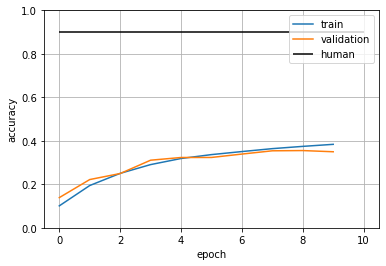

In [219]:
plt.plot(train_history, label='train')
plt.plot(test_history, label='validation')
plt.hlines(0.9, 0, 10, label='human')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.ylim((0,1))
plt.legend(loc='best')
plt.grid();

**Question :** quelles différences entre l'implémentation [Keras](https://keras.io/) et l'implémentatoin [PyTorch](https://pytorch.org/) ?

**Réponse :** les temps de calculs sont à peu près les mêmes, et les performances également. La différence réside essentiellement dans la syntaxe. [Keras](https://keras.io/) est plus facile à prendre en main, tandis que [PyTorch](https://pytorch.org/) est plus bas niveau et laisse toute la flexibilité à l'utilisateur. Excepté pour la gestions des régulations $L^1$ et $L^2$, qui se fait :
* couche par couche pendant la construction du réseau dans [Keras](https://keras.io/)
* de manière globale pendant l'instanciation du l'optimizer dans [PyTorch](https://pytorch.org/)

## Exercice n°16 : prédiction sur le jeu de test

<a class='anchor' id='exo16'></a>

Maintenant que le modèle est entraîné, on peut évaluer la performance sur le jeu de test.

**Consigne :** agréger `y_test` et `y_pred` sur tout le jeu de test.

**Indice :** on pourra s'inspirer de la fonction `evaluate` précédente. Les résultats seront rangés dans des tableaux numpy, initialisés via [numpy.empty](https://docs.scipy.org/doc/numpy/reference/generated/numpy.empty.html) et cumulés via [numpy.concatenate](https://docs.scipy.org/doc/numpy/reference/generated/numpy.concatenate.html). De plus, [PyTorch](https://pytorch.org/) offre la méthode [numpy](https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html#numpy-bridge) qui permet de convertir un tenseur en tableau.

In [220]:
y_test = np.array([], dtype=int)
y_pred = np.empty((0, len(classes)), dtype=int)
with torch.no_grad():
    for x_batch, y_batch in testloader:
        s_batch = model(x_batch)
        y_test = np.concatenate((y_test, y_batch.numpy()))
        y_pred = np.concatenate((y_pred, s_batch.numpy()))

**Question :** quelle est la dimension de `y_pred` ?

In [221]:
y_pred.shape

(10000, 100)

**Question :** est-ce que la somme des scores pour chaque ligne vaut bien 1 ?

**Réponse :** contrairement à [Keras](https://keras.io/), la couche softmax ne fait pas partie du réseau mais de la fonction de coût. La dernière couche donne donc des pré-activations comprises en $-\infty$ et $+\infty$.

In [222]:
s = y_pred.sum(axis=1)
s.min(), s.max()

(-37.19072914123535, -11.061221335083246)

**Question :** comment obtenir le numéro de la classe sur `y_test`? 

**Réponse :** contrairement à [Keras](https://keras.io/), il n'y a rien à faire, les labels n'ont pas subi de *one-hot encoding*.

**Question :** comment obtenir le numéro de la classe prédite sur `y_pred` ?

In [223]:
y_pred = y_pred.argmax(axis=1)

**Question :** quelle est l'exactitude (*accuracy*) du modèle sur le jeu de test ?

In [224]:
(y_test == y_pred).sum()/len(y_test)

0.3497

## Exercice n°17 : analyse d'erreurs

<a class='anchor' id='exo17'></a>

Dans cette exercice, on va essayer de compter le taux d'erreurs pour chaque classe séparément, de manière à comprendre si certaines classes sont plus faciles à prédire que d'autres et pourquoi. Cela revient à calculer une matrice de confusion tenant compte de toutes les possibilités.

**Consigne :** calculer la matrice de confusion qui comptabilise toutes les réponses prédites eu égard aux vrais labels.

**Indice :** on pourra se baser sur [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

In [225]:
cm = confusion_matrix(y_test, y_pred)

**Consigne :** extraire la diagonale `count` de la matrice de confusion afin de ne récupérer que les comptes de prédictions justes.

**Indice :** on pourra se baser sur [numpy.diag](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diag.html).

In [226]:
count = np.diag(cm)

**Consigne :** compter le nombre d'observations `total` pour chaque label.

**Indice :** on pourra se baser sur [numpy.bincount](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html).

In [227]:
total = np.bincount(y_test)

**Consigne :** en déduire le pourcentage `percent` de bonnes réponses classe par classe.

**Indice :** on pourra utiliser les variables `count` et `total` précédentes.

In [228]:
percent = count/total

**Consigne :** pour chaque classe, imprimer le pourcentage de bonne réponse.

**Indice :** on pourra appliquer [enumerate](https://docs.python.org/3/library/functions.html#enumerate) sur la variables `classes` pour interroger le résultat précédent `percent`.

In [229]:
for i, name in enumerate(classes):
    print('Accuracy of {}: {}'.format(name, percent[i]))

Accuracy of apple: 0.6
Accuracy of aquarium_fish: 0.52
Accuracy of baby: 0.07
Accuracy of bear: 0.14
Accuracy of beaver: 0.07
Accuracy of bed: 0.2
Accuracy of bee: 0.38
Accuracy of beetle: 0.36
Accuracy of bicycle: 0.42
Accuracy of bottle: 0.51
Accuracy of bowl: 0.21
Accuracy of boy: 0.12
Accuracy of bridge: 0.11
Accuracy of bus: 0.14
Accuracy of butterfly: 0.13
Accuracy of camel: 0.31
Accuracy of can: 0.38
Accuracy of castle: 0.74
Accuracy of caterpillar: 0.36
Accuracy of cattle: 0.17
Accuracy of chair: 0.54
Accuracy of chimpanzee: 0.54
Accuracy of clock: 0.22
Accuracy of cloud: 0.56
Accuracy of cockroach: 0.42
Accuracy of couch: 0.24
Accuracy of crab: 0.18
Accuracy of crocodile: 0.17
Accuracy of cup: 0.52
Accuracy of dinosaur: 0.31
Accuracy of dolphin: 0.25
Accuracy of elephant: 0.44
Accuracy of flatfish: 0.19
Accuracy of forest: 0.46
Accuracy of fox: 0.21
Accuracy of girl: 0.23
Accuracy of hamster: 0.4
Accuracy of house: 0.17
Accuracy of kangaroo: 0.27
Accuracy of keyboard: 0.12
Acc

# V. Conclusion

<a class='anchor' id='part5'></a>

Félicitations ! Vous voici arrivé au bout du second TP et des exercices sur la partie FCNN - CNN !

Pour aller plus loin sur la comparaison entre tf.keras et Pytorch, vous pouvez consulter [cet article de blog](https://ynd.co/blog/tensorflow-vs-pytorch) entre autres ressources.